In [2]:
%load_ext autoreload
%autoreload 2

In [6]:
# !pip install -r requirements.txt

#### Load in Nips dataframes and embeddings

In [1]:
import bert
import samples
import sklearn.mixture
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as  plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from utils import *
import pdb
import umap
import hdbscan


from numpy import dot
from numpy.linalg import norm
from sklearn.metrics import silhouette_score


#### Data Loading

In [2]:
# Combine 2018 2019 and 2022 dataframes and abstract embeddings
years = ["2018", "2019", "2022"]
nips_df = pd.read_csv(f"nips_{years[0]}_clean2.csv")
embeddings = load_embeddings(f"outputs/clean2_nips_{years[0]}_embeddings.pkl")
for year in years[1:]:
    current_df = pd.read_csv(f"nips_{year}_clean2.csv")
    nips_df = pd.concat([nips_df, current_df], ignore_index=True)
    del current_df
    current_embeddings = load_embeddings(f"outputs/clean2_nips_{year}_embeddings.pkl")
    embeddings = np.append(embeddings, current_embeddings, axis=0)
    del current_embeddings
    
nips_df

,Unnamed: 0,title,authors,abstract,year
0,0,Synthesized Policies for Transfer and Adaptati...,"Hexiang Hu, Liyu Chen, Boqing Gong, Fei Sha",The ability to transfer in reinforcement learn...,2018
1,1,Self-Supervised Generation of Spatial Audio fo...,"Pedro Morgado, Nuno Nvasconcelos, Timothy Lang...",We introduce an approach to convert mono audio...,2018
2,2,On GANs and GMMs,"Eitan Richardson, Yair Weiss",A longstanding problem in machine learning is ...,2018
3,3,Batch-Instance Normalization for Adaptively St...,"Hyeonseob Nam, Hyo-Eun Kim",Real-world image recognition is often challeng...,2018
4,4,Hierarchical Reinforcement Learning for Zero-s...,"Sungryull Sohn, Junhyuk Oh, Honglak Lee",We introduce a new RL problem where the agent ...,2018
...,...,...,...,...,...
4502,2619,Cost-efficient Gaussian tensor network embeddi...,"Linjian Ma, Edgar Solomonik","This work discusses tensor network embeddings,...",2022
4503,2620,Neural Transmitted Radiance Fields,"Chengxuan Zhu, Renjie Wan, Boxin Shi",Neural radiance fields (NeRF) have brought tre...,2022
4504,2622,Structural Kernel Search via Bayesian Optimiza...,"Matthias Bitzer, Mona Meister, Christoph Zimmer",Despite recent advances in automated machine l...,2022
4505,2623,Near-Optimal No-Regret Learning Dynamics for G...,"Gabriele Farina, Ioannis Anagnostides, Haipeng...",A recent line of work has established un...,2022


In [3]:
nips_df.head()

,Unnamed: 0,title,authors,abstract,year
0,0,Synthesized Policies for Transfer and Adaptati...,"Hexiang Hu, Liyu Chen, Boqing Gong, Fei Sha",The ability to transfer in reinforcement learn...,2018
1,1,Self-Supervised Generation of Spatial Audio fo...,"Pedro Morgado, Nuno Nvasconcelos, Timothy Lang...",We introduce an approach to convert mono audio...,2018
2,2,On GANs and GMMs,"Eitan Richardson, Yair Weiss",A longstanding problem in machine learning is ...,2018
3,3,Batch-Instance Normalization for Adaptively St...,"Hyeonseob Nam, Hyo-Eun Kim",Real-world image recognition is often challeng...,2018
4,4,Hierarchical Reinforcement Learning for Zero-s...,"Sungryull Sohn, Junhyuk Oh, Honglak Lee",We introduce a new RL problem where the agent ...,2018


#### Pick a range of dimensions and parameters to train clustering models

In [4]:
dim_range = [-1] + list(range(5, 750, 50))
num_cluster_range = [0]
cluster_algorithm = "dbscan"
cluster_models, dim_reduce_models, scores = dim_reduce_train_cluster(embeddings, cluster_algorithm,  "umap", "sil", dim_range=dim_range, num_cluster_range=num_cluster_range, saving_path="outputs/dbscan2")

  6%|▋         | 1/16 [00:52<13:04, 52.30s/it]

-1


 12%|█▎        | 2/16 [01:20<08:56, 38.33s/it]

0.42769167


 19%|█▉        | 3/16 [01:29<05:21, 24.77s/it]

-0.12051793


 25%|██▌       | 4/16 [01:42<04:00, 20.04s/it]

0.4231442


 31%|███▏      | 5/16 [01:58<03:24, 18.55s/it]

-0.16525492


 38%|███▊      | 6/16 [02:17<03:07, 18.75s/it]

0.5344626


 44%|████▍     | 7/16 [02:40<03:01, 20.19s/it]

-0.022879984


 50%|█████     | 8/16 [03:06<02:56, 22.08s/it]

-0.1958335


 56%|█████▋    | 9/16 [03:35<02:48, 24.14s/it]

0.45490122


 62%|██████▎   | 10/16 [04:09<02:42, 27.15s/it]

0.45269278


 69%|██████▉   | 11/16 [04:45<02:30, 30.02s/it]

0.48083547


 75%|███████▌  | 12/16 [05:28<02:15, 33.90s/it]

-0.15647171


 81%|████████▏ | 13/16 [06:18<01:56, 38.75s/it]

-0.020414043


 88%|████████▊ | 14/16 [07:17<01:29, 44.86s/it]

0.4595221


 94%|█████████▍| 15/16 [08:18<00:49, 49.90s/it]

0.48998907


100%|██████████| 16/16 [09:27<00:00, 35.46s/it]

-0.17922433


In [5]:
dim_range

[-1, 5, 55, 105, 155, 205, 255, 305, 355, 405, 455, 505, 555, 605, 655, 705]

In [6]:
scores

{(-1, 0): -1,
 (5, 0): 0.42769167,
 (55, 0): -0.12051793,
 (105, 0): 0.4231442,
 (155, 0): -0.16525492,
 (205, 0): 0.5344626,
 (255, 0): -0.022879984,
 (305, 0): -0.1958335,
 (355, 0): 0.45490122,
 (405, 0): 0.45269278,
 (455, 0): 0.48083547,
 (505, 0): -0.15647171,
 (555, 0): -0.020414043,
 (605, 0): 0.4595221,
 (655, 0): 0.48998907,
 (705, 0): -0.17922433}

In [7]:
list(scores.values())

[-1,
 0.42769167,
 -0.12051793,
 0.4231442,
 -0.16525492,
 0.5344626,
 -0.022879984,
 -0.1958335,
 0.45490122,
 0.45269278,
 0.48083547,
 -0.15647171,
 -0.020414043,
 0.4595221,
 0.48998907,
 -0.17922433]

In [9]:
dim_range = [-1]+list(range(5, 750, 50))
select_dims_0, select_scores_0 = simplify_scores(scores, dim_range, [0], True)

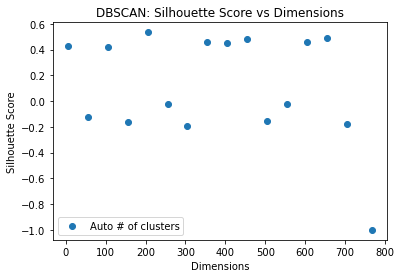

In [10]:
# visualize the model scores
plt.scatter(select_dims_0, select_scores_0)
plt.legend(["Auto # of clusters"])
plt.title("DBSCAN: Silhouette Score vs Dimensions")
plt.ylabel("Silhouette Score")
plt.xlabel("Dimensions")
plt.show()

In [13]:
scores[205,0]

0.5344626

In [10]:
# # model = cluster_models[(705, 5)]

# file = open("./outputs/dbscan1/dim_705_dbscan_0.pkl", 'rb')
# model = pickle.load(file)
# file.close()

In [12]:
# # reduce_dim_model = dim_reduce_models[705]
# file = open("./outputs/dbscan1/dim_705.pkl", 'rb')
# reduce_dim_model = pickle.load(file)
# file.close()

In [15]:
# we do not store models for DBSCAN because it does not return a model, instead we regenerate labels using the same dimensional reduction model
reduce_dim_model = dim_reduce_models[205]

In [16]:
reduced_embeddings = reduce_dim_model.transform(embeddings)

In [17]:
# reduce dimensions to 5 using umap
# lower_dim = 555
# reduced_embeddings, reduce_dim_model = reduce_dim(embeddings, "umap", lower_dim)
# reduced_embeddings = embeddings
# cluster
cluster_algorithm = "dbscan" # dbscan/gmm

clusters, model = cluster_and_predict(reduced_embeddings, cluster_algorithm, num_cluster=10)
# saving_path = "outputs/dim_200"
# os.makedirs(saving_path, exist_ok=True)
# models, losses = train_cluster(reduced_embeddings, cluster_algorithm, "sil", range(2, 40, 3), saving_path=saving_path)

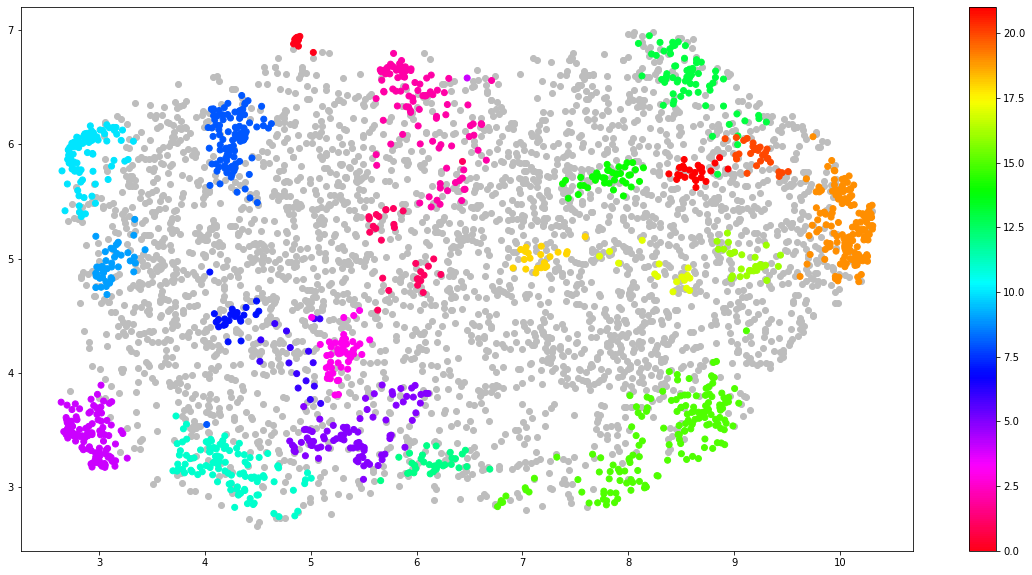

In [18]:
if cluster_algorithm == "gmm":
    paper_labels = clusters
elif cluster_algorithm == "kmeans":
    paper_labels = clusters
elif cluster_algorithm == "dbscan":
    paper_labels = clusters.labels_

# for dbscan
# visualize(embeddings, clusters.labels_)

# for gmm
visualize(embeddings, paper_labels)


In [19]:
dic = {}
# for dbscan
# dic = metrics(["sil"], reduced_embeddings, clusters.labels_, dic)

# for gmm
knowns = paper_labels != -1
dic = metrics(["sil"], reduced_embeddings[knowns], paper_labels[knowns], dic)

print(dic) # the score should match the score for the same dimension in scores (next cell output)

{'sil': 0.5344626}


In [20]:
scores

{(-1, 0): -1,
 (5, 0): 0.42769167,
 (55, 0): -0.12051793,
 (105, 0): 0.4231442,
 (155, 0): -0.16525492,
 (205, 0): 0.5344626,
 (255, 0): -0.022879984,
 (305, 0): -0.1958335,
 (355, 0): 0.45490122,
 (405, 0): 0.45269278,
 (455, 0): 0.48083547,
 (505, 0): -0.15647171,
 (555, 0): -0.020414043,
 (605, 0): 0.4595221,
 (655, 0): 0.48998907,
 (705, 0): -0.17922433}

#### Provide an overview of the topics

In [21]:
nips_df, docs_per_topic = create_docs_per_topic(nips_df, paper_labels)

tf_idf, count = c_tf_idf(docs_per_topic.abstract.values, m=len(nips_df))

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(nips_df); topic_sizes.head(10)

,Topic,Size
0,-1,3148
20,19,155
16,15,154
5,4,118
12,11,106
3,2,102
9,8,100
11,10,98
6,5,88
14,13,68


In [22]:
print(topic_sizes)

    Topic  Size
0      -1  3148
20     19   155
16     15   154
5       4   118
12     11   106
3       2   102
9       8   100
11     10    98
6       5    88
14     13    68
4       3    51
10      9    42
15     14    38
13     12    34
2       1    30
17     16    28
21     20    27
22     21    26
8       7    23
19     18    23
7       6    16
1       0    16
18     17    16


In [30]:
top_n_words[0][:10]

[('molecules', 0.05582297472090415),
 ('protein', 0.045972531501031755),
 ('drug', 0.043619227407517246),
 ('molecular', 0.03665974868722927),
 ('chemical', 0.028682710550000205),
 ('molecule', 0.028135541109192107),
 ('compounds', 0.024682985290176696),
 ('binding', 0.023623233500636918),
 ('proteins', 0.023045215090086016),
 ('conformation', 0.022391726048362384)]

#### Accept a user input, Find the relevant cluster and suggests papers

In [31]:
# initialize Bert model for embedding
bert_model = BertForEmbedding()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [49]:
# use bert to verterize input
# sample_embedding = bert_model.bertify_single_abstract(sample_entry["abstract"])
# sample_embedding = bert_model.bertify_single_abstract("Value-function-based methods have long played an important role in reinforcement learning. However, finding the best next action given a value function of arbitrary complexity is nontrivial when the action space is too large for enumeration. We develop a framework for value-function-based deep reinforcement learning with a combinatorial action space, in which the action selection problem is explicitly formulated as a mixed-integer optimization problem. As a motivating example, we present an application of this framework to the capacitated vehicle routing problem (CVRP), a combinatorial optimization problem in which a set of locations must be covered by a single vehicle with limited capacity. On each instance, we model an action as the construction of a single route, and consider a deterministic policy which is improved through a simple policy iteration algorithm. Our approach is competitive with other reinforcement learning methods and achieves an average gap of 1.7% with state-of-the-art OR methods on standard library instances of medium size.")
sample_embedding = bert_model.bertify_single_abstract("Reinforcement Learning")
# sample_embedding = bert_model.bertify_single_abstract("Image generation")


sample_embedding.shape

torch.Size([1, 768])

In [50]:
sample_embedding = reduce_dim_model.transform(sample_embedding.cpu())

# (sample_embedding, "umap", lower_dim)
# sample_class = model.predict(sample_embedding)

sample_class = hdbscan.approximate_predict(clusters, sample_embedding)[0]
# sample_class = np.array(4)
print(f"The predicted cluster is: {sample_class}")
if cluster_algorithm == "dbscan":
    sample_class += 1
top_n_words[sample_class.item()][:10]

The predicted cluster is: [-1]


[('molecules', 0.05582297472090415),
 ('protein', 0.045972531501031755),
 ('drug', 0.043619227407517246),
 ('molecular', 0.03665974868722927),
 ('chemical', 0.028682710550000205),
 ('molecule', 0.028135541109192107),
 ('compounds', 0.024682985290176696),
 ('binding', 0.023623233500636918),
 ('proteins', 0.023045215090086016),
 ('conformation', 0.022391726048362384)]

In [51]:
sample_class

array([0])

In [52]:
# x = embeddings[10]
# x_class = paper_labels[10]
# x_class

In [53]:
relevant_embeddings, relevant_df = select_cluster(sample_class, reduced_embeddings, nips_df, paper_labels)

# relevant_embeddings, relevant_df = select_cluster(sample_class, embeddings, nips_df, paper_labels)
relevant_embeddings = reduced_embeddings
relevant_df = nips_df
scores = cos_sim(sample_embedding, relevant_embeddings)
best_matches = np.argsort(scores)[-20:][::-1]
for i, match_idx in enumerate(best_matches):
  print(f"score: {scores[match_idx]}")
  print(f"title: {relevant_df.iloc[match_idx]['title']}")
  print(f"abstract: {relevant_df.iloc[match_idx]['abstract']}")

score: 0.999972939491272
title: Interactive Structure Learning with Structural Query-by-Committee
abstract: In this work, we introduce interactive structure learning, a framework that unifies many different interactive learning tasks. We present a generalization of the query-by-committee active learning algorithm for this setting, and we study its consistency and rate of convergence, both theoretically and empirically, with and without noise.
score: 0.9999727606773376
title: Zero-Shot Transfer with Deictic Object-Oriented Representation in Reinforcement Learning
abstract: Object-oriented representations in reinforcement learning have shown promise in transfer learning, with previous research introducing a propositional object-oriented framework that has provably efficient learning bounds with respect to sample complexity. However, this framework has limitations in terms of the classes of tasks it can efficiently learn. In this paper we introduce a novel deictic object-oriented framewor

In [54]:
np.min(scores)

0.99866647